# 2025-1 Artificial Intelligence (01)
## Homework #4: Simple Conditional Diffusion Model
---
Copyright (c) Prof. Jaehyeong Sim

Department of Computer Science and Engineering

College of Artificial Intelligence

Ewha Womans University

## Guideline
### Introduction
> Here in this homework assignment 4, we will learn a simple conditional diffusion model that generates images from CIFAR-10 dataset using PyTorch.

### Your job
> Please read the code and breifly summarize how this code works within in one page. You may focus on how the diffusion model learns and samples in addition to the explanation about the backbone.

### Submission guide
1. Make your PDF file name **STUDENT_ID.pdf** that contains your summary. We only accept PDF format.
2. Turn in it into the Ewha CyberCampus.

⚠ If you doesn't follow the submission guide above, you will get **5 point deduction** from this homework score.

### Deadline
*   June 22, 23:59

### 1. Importing Necessary Libraries and GPU Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import copy, math, random, os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed=42):
    """
    Set seed for reproducing training results
    """
    # Python random
    random.seed(seed)

    # Numpy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

    # DataLoader worker seed
    def worker_init_fn(worker_id):
        np.random.seed(seed + worker_id)

    return worker_init_fn

worker_init_fn = set_seed(42)

Using device: cuda


### 2. Preparing the Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalization
])

# Use CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

class BinaryCIFAR10(torch.utils.data.Dataset):
    def __init__(self, base_dataset, indices):
        self.base = base_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.base[self.indices[idx]]
        binary_label = 0 if label == 1 else 1  # automobile -> 0, cat -> 1
        return img, binary_label


# DataLoader instantiation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

### 3. Defining Diffusion Process

In [ ]:
class DiffusionProcess:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_timesteps = num_timesteps

        # Linear beta schedule
        self.betas = self.cosine_beta_schedule(num_timesteps, beta_start, beta_end)

        # Alpha and alpha_bar calculation
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)

        # Offline calculation for computational efficiency
        self.sqrt_alphas_bar = torch.sqrt(self.alphas_bar).to(device)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(1 - self.alphas_bar).to(device)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_recipm1_alphas_bar = torch.sqrt(1.0 / self.alphas_bar - 1)

    def cosine_beta_schedule(self, timesteps, beta_start=0.0001, beta_end=0.02, s=0.008):
        """
        Cosine schedule as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
        """
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, beta_start, beta_end)

    def add_noise(self, x_0, t):
        """Forward diffusion process"""
        batch_size = x_0.shape[0]
        t = t.to(device)

        # Get parameters for each sample
        sqrt_alpha_bar = self.sqrt_alphas_bar[t].reshape(batch_size, 1, 1, 1)
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alphas_bar[t].reshape(batch_size, 1, 1, 1)

        # Gaussian noise creation
        noise = torch.randn_like(x_0)

        # Applying forward diffusion process
        noisy_image = sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise

        return noisy_image, noise

### 4. Implementing Conditional U-Net

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim, max_steps: int = 1_000):
        super().__init__()
        self.dim = dim
        self.max_steps = max_steps

    def forward(self, time):
        time = time.float() / self.max_steps

        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, out_channels)
        self.activation = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, out_channels)

        # An MLP layer for time and class embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, out_channels),
            nn.SiLU()
        )

        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.residual_conv = nn.Identity()

    def forward(self, x, emb):

        residual = self.residual_conv(x)
        h = self.conv1(x)
        h = self.gn1(h)
        h = self.activation(h)
        time_proj = self.time_mlp(emb)
        h = h + time_proj.unsqueeze(-1).unsqueeze(-1)

        h = self.conv2(h)
        h = self.gn2(h)

        return self.activation(h + residual)

In [ ]:
class ConditionalUNet(nn.Module):
    """Class-conditional U-Net for CIFAR-10"""
    def __init__(self, in_channels=3, out_channels=3, num_classes=10, time_dim=256):
        super().__init__()
        self.time_dim = time_dim
        self.num_classes = num_classes

        # Time embedding layers
        self.time_emb_module = SinusoidalPositionEmbeddings(time_dim)

        self.emb_mlp = nn.Sequential(
            nn.Linear(time_dim * 2, time_dim * 2),
            nn.SiLU(),
            nn.Linear(time_dim * 2, time_dim),
        )

        # Class embedding layer
        self.class_emb = nn.Embedding(num_classes, time_dim)

        # Encoder (down-sampling)
        self.down1 = ConvBlock(in_channels, 64, time_dim)
        self.down2 = ConvBlock(64, 128, time_dim)
        self.down3 = ConvBlock(128, 256, time_dim)
        self.down4 = ConvBlock(256, 512, time_dim)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 512, time_dim)

        # Decoder (up-sampling)
        self.up4 = ConvBlock(512 + 512, 256, time_dim)
        self.up3 = ConvBlock(256 + 256, 128, time_dim)
        self.up2 = ConvBlock(128 + 128, 64, time_dim)
        self.up1 = ConvBlock(64 + 64, 64, time_dim)

        # Final output layer
        self.final = nn.Conv2d(64, out_channels, 1)

        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t, class_label=None):
        # Time embedding
        t_emb = self.time_emb_module(t)

        # Class conditioning
        class_emb = self.class_emb(class_label)

        emb = torch.cat([t_emb, class_emb], dim=-1)
        emb = self.emb_mlp(emb)

        # --- Encoder ---
        down1 = self.down1(x, emb)
        x = self.pool(down1)

        down2 = self.down2(x, emb)
        x = self.pool(down2)

        down3 = self.down3(x, emb)
        x = self.pool(down3)

        down4 = self.down4(x, emb)
        x = self.pool(down4)

        # --- Bottleneck ---
        x = self.bottleneck(x, emb)

        # --- Decoder with skip connections ---
        x = self.upsample(x)
        x = torch.cat([x, down4], dim=1)
        x = self.up4(x, emb)

        x = self.upsample(x)
        x = torch.cat([x, down3], dim=1)
        x = self.up3(x, emb)

        x = self.upsample(x)
        x = torch.cat([x, down2], dim=1)
        x = self.up2(x, emb)

        x = self.upsample(x)
        x = torch.cat([x, down1], dim=1)
        x = self.up1(x, emb)

        # Final output
        x = self.final(x)
        return x

### 5. Training Loop

In [ ]:
@torch.no_grad()
def update_ema(model: nn.Module, ema_model: nn.Module, decay: float):
    model_params     = dict(model.named_parameters())
    ema_model_params = dict(ema_model.named_parameters())

    for name in model_params.keys():
        ema_param = ema_model_params[name]
        model_param = model_params[name]
        ema_param.data.mul_(decay).add_(model_param.data, alpha=1 - decay)

In [ ]:
def train_conditional_diffusion(model, ema_model, ema_decay, diffusion, train_loader, num_epochs=100, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=2e-4,
      total_steps=num_epochs * len(train_loader)
    )

    train_losses = []

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = []
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Selecting random timestep
            batch_size = images.shape[0]
            t = torch.randint(0, diffusion.num_timesteps, (batch_size,), device=device)

            # Noise addition with forward diffusion
            noisy_images, noise = diffusion.add_noise(images, t)

            # Model inference for predicting noise
            predicted_noise = model(noisy_images, t, labels)

            # Loss calculation
            loss = criterion(predicted_noise, noise)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            update_ema(model, ema_model, ema_decay)
            epoch_loss.append(loss.item())

            if batch_idx % 100 == 0:
                last_loss = np.mean(epoch_loss[-10:]) if epoch_loss else loss
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {last_loss:.5f}')


        avg_loss = np.mean(epoch_loss)
        train_losses.append(avg_loss)

    return train_losses

### 6. Conditional Sampling

In [ ]:
@torch.no_grad()
def sample_conditional_images(model, diffusion, class_labels, num_samples=4, image_size=(3, 32, 32)):
    """Conditional reverse diffusion process"""
    model.eval()
    device = next(model.parameters()).device

    if isinstance(class_labels, int):
        class_labels = [class_labels] * num_samples
    class_labels = torch.tensor(class_labels, device=device)

    # Start with pure noise
    x_t = torch.randn(num_samples, *image_size, device=device)

    # Reverse diffusion process
    for t in reversed(range(diffusion.num_timesteps)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)

        predicted_noise = model(x_t, t_tensor, class_labels)

        alpha_t = diffusion.alphas[t].to(device)
        alpha_bar_t = diffusion.alphas_bar[t].to(device)
        beta_t = diffusion.betas[t].to(device)

        if t > 0:
            alpha_bar_t_minus_1 = diffusion.alphas_bar[t-1].to(device)
            sigma_t = torch.sqrt((1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t) * beta_t)
            noise = torch.randn_like(x_t)
        else:
            sigma_t = 0
            noise = torch.zeros_like(x_t)

        coeff = beta_t / torch.sqrt(1 - alpha_bar_t)
        x_t = (1 / torch.sqrt(alpha_t)) * (x_t - coeff * predicted_noise) + sigma_t * noise

    x_t = (x_t + 1) / 2
    x_t = torch.clamp(x_t, 0, 1)

    return x_t

### 7. Visualization

In [ ]:
def plot_beta_schedule(diffusion):
    """Visualizing beta schedule and related parameters"""
    fig, axes = plt.subplots(1, 2, figsize=(9, 3))

    # Beta schedule
    axes[0].plot(diffusion.betas.numpy())
    axes[0].set_title('Beta Schedule')
    axes[0].set_xlabel('Timestep')
    axes[0].set_ylabel('Beta_t')
    axes[0].grid(True)

    # Alpha schedule
    axes[1].plot(diffusion.alphas.numpy())
    axes[1].set_title('Alpha Schedule')
    axes[1].set_xlabel('Timestep')
    axes[1].set_ylabel('Alpha_t')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def visualize_conditional_generation(model, diffusion):
    """Visualize samples for each class"""
    fig, axes = plt.subplots(2, 5, figsize=(9, 3))
    axes = axes.flatten()

    for i, class_name in enumerate(classes):
        # One for each class
        generated = sample_conditional_images(model, diffusion, i, num_samples=1)

        axes[i].imshow(generated[0].cpu().permute(1, 2, 0))
        axes[i].set_title(f'{class_name}')
        axes[i].axis('off')

    plt.suptitle('Conditional Generation: One Sample per Class')
    plt.tight_layout()
    plt.show()

### 8. Execution scripts

In [ ]:
# Instantiation of the model and diffusion process
diffusion = DiffusionProcess(num_timesteps=1000)
model = ConditionalUNet(num_classes=10).to(device)

Visualizing beta schedule...


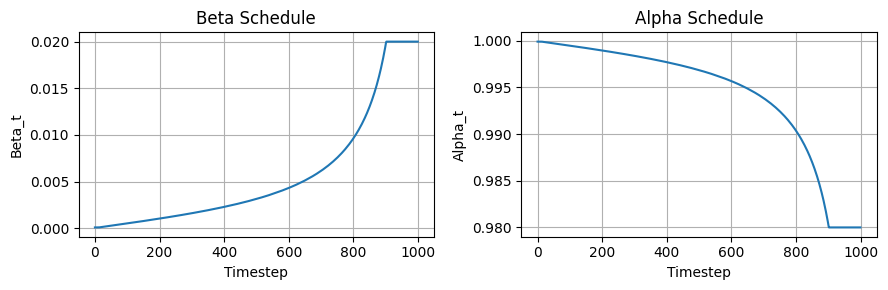

In [ ]:
# Visualizing beta schedule
print("Visualizing beta schedule...")
plot_beta_schedule(diffusion)

In [ ]:
# Training
print("Training conditional diffusion model...")
ema_model = copy.deepcopy(model).to(device).eval()
for p in ema_model.parameters():
    p.requires_grad_(False)
ema_decay = 0.999

losses = train_conditional_diffusion(model, ema_model, ema_decay, diffusion, train_loader)

Training conditional diffusion model...
Epoch 1/100, Batch 0/782, Loss: 1.21826
Epoch 1/100, Batch 100/782, Loss: 0.66469
Epoch 1/100, Batch 200/782, Loss: 0.34133
Epoch 1/100, Batch 300/782, Loss: 0.22276
Epoch 1/100, Batch 400/782, Loss: 0.19137
Epoch 1/100, Batch 500/782, Loss: 0.16448
Epoch 1/100, Batch 600/782, Loss: 0.15263
Epoch 1/100, Batch 700/782, Loss: 0.13717
Epoch 2/100, Batch 0/782, Loss: 0.12224
Epoch 2/100, Batch 100/782, Loss: 0.12398
Epoch 2/100, Batch 200/782, Loss: 0.13541
Epoch 2/100, Batch 300/782, Loss: 0.12536
Epoch 2/100, Batch 400/782, Loss: 0.11868
Epoch 2/100, Batch 500/782, Loss: 0.11369
Epoch 2/100, Batch 600/782, Loss: 0.11807
Epoch 2/100, Batch 700/782, Loss: 0.10524
Epoch 3/100, Batch 0/782, Loss: 0.08637
Epoch 3/100, Batch 100/782, Loss: 0.10670
Epoch 3/100, Batch 200/782, Loss: 0.10470
Epoch 3/100, Batch 300/782, Loss: 0.10403
Epoch 3/100, Batch 400/782, Loss: 0.10026
Epoch 3/100, Batch 500/782, Loss: 0.08855
Epoch 3/100, Batch 600/782, Loss: 0.09883


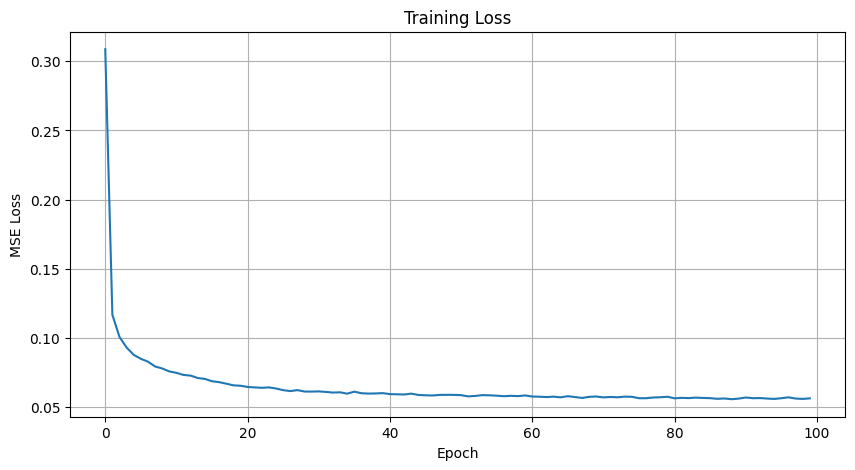

In [ ]:
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

Generating images for each class...


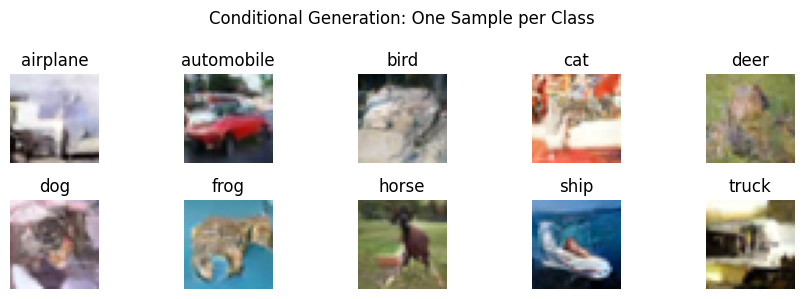

In [ ]:
# Generating images for each class
print("Generating images for each class...")
visualize_conditional_generation(ema_model, diffusion)

Generating multiple cats...


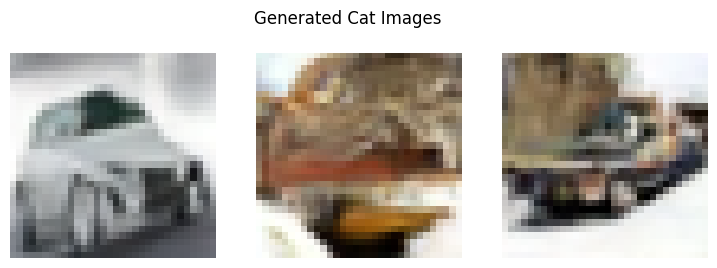

In [ ]:
# Generating images for a single class (cat)
print("Generating multiple cats...")
cat_images = sample_conditional_images(ema_model, diffusion, class_labels=1, num_samples=3)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(cat_images[i].cpu().permute(1, 2, 0))
    ax.axis('off')
plt.suptitle('Generated Cat Images')
plt.show()